In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from kloppy.domain.models import Point
from typing import Sequence

In [2]:
def generate_shot_paths(
        shot_location: Point,
        num_potential_paths: int = 100,
        goalpost_locations: tuple[Point, Point] = (Point(120, 36), Point(120, 44))
):
    assert goalpost_locations[0].x == goalpost_locations[1].x
    paths = []
    for path_end_y in np.linspace(
        goalpost_locations[0].y, goalpost_locations[1].y, num_potential_paths
    ):
        paths.append({
            "x1": shot_location.x, "x2": goalpost_locations[0].x,
            "y1": shot_location.y, "y2": path_end_y,
            "slope_ab": (path_end_y - shot_location.y) / (goalpost_locations[0].x - shot_location.x)
        })
    return pd.DataFrame(paths)

generate_shot_paths(Point(100, 32)).head()

,x1,x2,y1,y2,slope_ab
0,100,120,32,36.000000,0.200000
1,100,120,32,36.080808,0.204040
2,100,120,32,36.161616,0.208081
3,100,120,32,36.242424,0.212121
4,100,120,32,36.323232,0.216162


In [3]:
import math
def generate_player_intercepts(player_location: Point, shot_location: Point, offset: float):
    theta = math.atan2(shot_location.y - player_location.y, shot_location.x - player_location.x)
    # Rotation matrix
    offset_x = -offset * math.sin(theta)
    offset_y = offset * math.cos(theta)
    intercept_1 = Point(player_location.x + offset_x, player_location.y + offset_y)
    intercept_2 = Point(player_location.x - offset_x, player_location.y - offset_y)
    return intercept_1, intercept_2

In [51]:
def calculate_intersections_for_player(
        shot_location: Point,
        shot_paths: pd.DataFrame,
        player_location: Point,
        buffer: float
):
    player_start, player_end = generate_player_intercepts(
        player_location, shot_location, buffer
    )
    # Call the shot location A, the intersection of the potential shot trajectory
    # and the goal B, one side of a defender's maximum reach C, and the other side D.
    # slope(AB) is already calculated in generate_shot_paths (as slope_ab).
    slope_ac = (player_start.y - shot_location.y) / (player_start.x - shot_location.x)
    slope_ad = (player_end.y - shot_location.y) / (player_end.x - shot_location.x)
    slope_bc = (player_start.y - shot_paths.y2) / (player_start.x - shot_paths.x2)
    slope_bd = (player_end.y - shot_paths.y2) / (player_end.x - shot_paths.x2)
    # See here for more details on this algorithm: https://bryceboe.com/2006/10/23/line-segment-intersection-algorithm/
    ccw_acd = (slope_ac < slope_ad)
    ccw_bcd = (slope_bc < slope_bd)
    ccw_abc = (shot_paths.slope_ab < slope_ac)
    ccw_abd = (shot_paths.slope_ab < slope_ad)
    intersects = (ccw_acd != ccw_bcd) & (ccw_abc != ccw_abd)
    return intersects

def calculate_intersections(
        shot_location: Point,
        player_locations: Sequence[Point],
        buffer=0.5,
        num_potential_paths: int = 100,
        goalpost_locations: tuple[Point, Point] = (Point(120, 36), Point(120, 44))
):
    shot_paths = generate_shot_paths(shot_location, num_potential_paths, goalpost_locations)
    shot_paths["num_intersections"] = 0
    for player_location in player_locations:
        shot_paths["num_intersections"] += calculate_intersections_for_player(
            shot_location, shot_paths, player_location, buffer
        )
    return shot_paths


# def determinant(a, b):
#     return a[0] * b[1] - a[1] * b[0]

# def test(
#         shot_location: Point,
#         shot_paths: pd.DataFrame,
#         player_location: Point,
#         buffer: float
# ):
#     player_start, player_end = generate_player_intercepts(
#         player_location, shot_location, buffer
#     )
#     xdiffs = (shot_paths.x2 - shot_paths.x1, player_end.x - player_start.x)
#     ydiffs = (shot_paths.y2 - shot_paths.y1, player_end.y - player_start.y)
#     div = determinant(xdiffs, ydiffs)
#     d1 = determinant((shot_paths.x1, shot_paths.y1), (shot_paths.x2,shot_paths.y2))
#     d2 = determinant((player_start.x, player_start.y), (player_end.x, player_end.y))
#     xes = determinant((d1, d2), xdiffs) / div
#     yes = determinant((d1, d2), ydiffs) / div
#     return 

In [57]:
shot_paths_1 = (100, 32)
shot_paths_2 = (120, 36)

player_1 = (101, 30.5)
player_2 = (101, 31.5)

def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

line_intersection((shot_paths_1, shot_paths_2), (player_1, player_2))

(101.0, 32.2)

In [53]:
shot = Point(100, 32)
player_positions = [
    Point(110, 32),
    Point(110, 40),
    Point(110, 26),
    Point(95, 36),
    Point(115, 36),
    Point(105, 35),
    Point(102, 32)
]


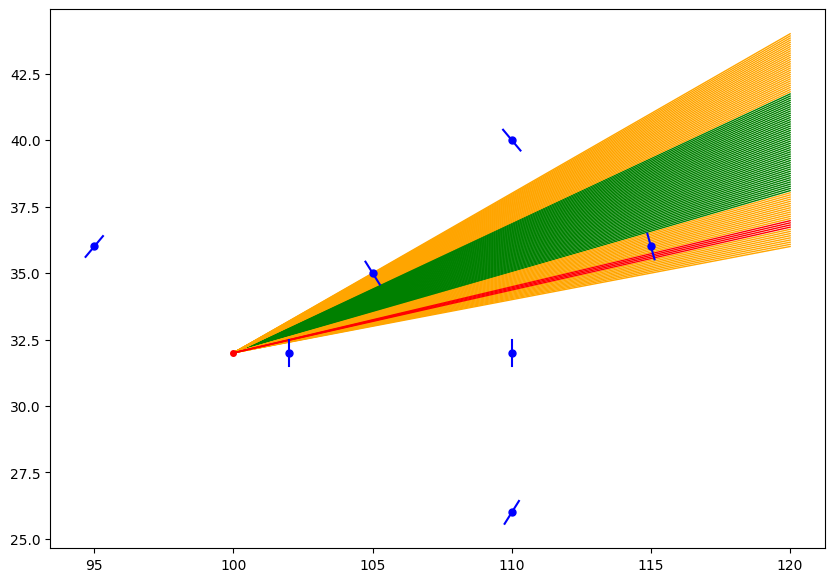

In [54]:
paths = calculate_intersections(shot, player_positions)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
   
colors = ["green", "orange", "red"]
for n_intersects in paths.num_intersections.value_counts().index.sort_values():
    for path in paths[paths.num_intersections == n_intersects].itertuples():
        color = colors[n_intersects]
        lw = 1
        ax.plot([path.x1, path.x2], [path.y1, path.y2], color=color, lw=lw)
        
        
ax.plot([shot.x], [shot.y], color="red", marker="o", ms=4)
for player_position in player_positions:
    intercept_1, intercept_2 = generate_player_intercepts(player_position, shot, 0.5)
    ax.plot([player_position.x], [player_position.y], color="blue", marker="o", ms=5)
    ax.plot([intercept_1.x, intercept_2.x], [intercept_1.y, intercept_2.y], color="blue")

In [60]:
from sklearn.model_selection import train_test_split
from soccer_analytics.data.statsbomb import load_competition_seasons
from soccer_analytics.data_split import split_by_time
matches = load_competition_seasons(
    "FIFA World Cup", ["2022"], event_types=["shot"]
)
train_test_matches, _ = split_by_time(matches, test_frac=0.2)
train_matches, test_matches = train_test_split(
    train_test_matches, test_size=0.2, random_state=235
)
len(train_matches)

40

In [61]:
def match_list_to_df(match_list):
    df_list = []
    for match in match_list:
        df_list.append(match.to_df(
            "is_penalty",
            "is_first_time",
            "statsbomb_xg",
            "technique",
            "coordinates*",
            position=lambda event: "Unknown" if event.player.position is None else event.player.position.name,
            is_goal=lambda event: int(event.result.is_success),
            is_blocked=lambda event: int(event.result.name == "BLOCKED"),
            timestamp=lambda event: event.timestamp,
            raw_data=lambda event: event.raw_event
        ))
    return pd.concat(df_list)
train_df = match_list_to_df(train_matches)
train_df.head()

,is_penalty,is_first_time,statsbomb_xg,technique,coordinates_x,coordinates_y,position,is_goal,is_blocked,timestamp,raw_data
0,False,True,0.018983,Volley,94.95,47.75,Right Wing,0,1,92.843,"{'id': 'ae689327-02fd-48ca-9b36-cee4f2ebc4a1',..."
1,False,False,0.030385,Normal,89.45,39.05,Left Center Midfield,0,0,145.400,"{'id': '41bfd8e2-a7dd-4775-b08e-5b6725676461',..."
2,False,True,0.191471,Half Volley,114.15,31.25,Left Midfield,1,0,504.985,"{'id': 'ba50751b-2a8a-400c-97a5-3da7ba7f6a94',..."
3,False,True,0.017693,Volley,92.65,33.95,Unknown,0,0,746.873,"{'id': 'ed13ed99-0339-47a0-9aa7-bc422ca3d494',..."
4,False,False,0.017897,Normal,91.05,46.85,Center Forward,0,0,1265.119,"{'id': '932fcf66-fb88-4ec2-9afa-adffa29e27fe',..."


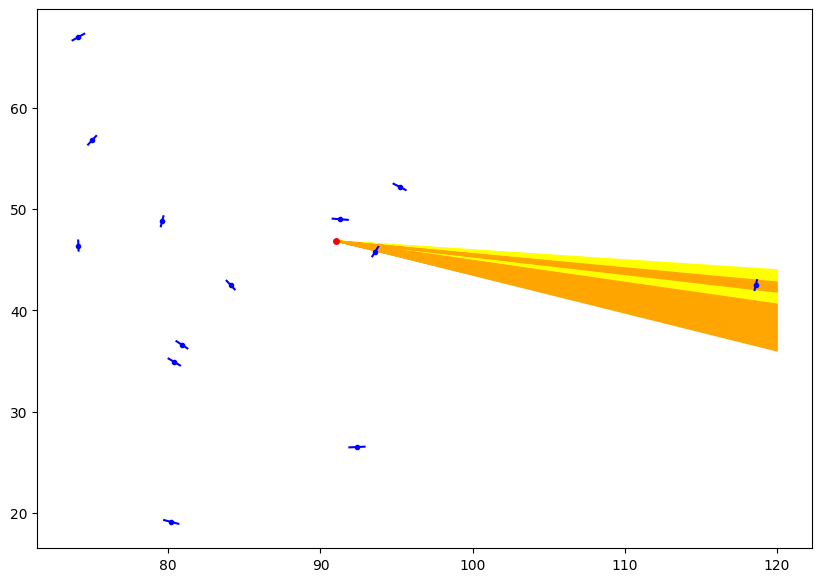

In [91]:
row = train_df.iloc[4]
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

shot = Point(row.coordinates_x, row.coordinates_y)
player_positions = [
    Point(player["location"][0], player["location"][1])
    for player in row.raw_data["shot"]["freeze_frame"]
]

paths = calculate_intersections(shot, player_positions)

   
colors = ["green", "yellow", "orange", "red", "brown", "black"]
for n_intersects in paths.num_intersections.value_counts().index.sort_values():
    for path in paths[paths.num_intersections == n_intersects].itertuples():
        color = colors[n_intersects]
        lw = 1
        ax.plot([path.x1, path.x2], [path.y1, path.y2], color=color, lw=lw)
        

ax.plot([row.coordinates_x], [row.coordinates_y], color="red", marker="o", ms=4)
for player_position in player_positions:
    intercept_1, intercept_2 = generate_player_intercepts(
        player_position, shot, 0.5
    )
    ax.plot([player_position.x], [player_position.y], color="blue", marker="o", ms=3)
    ax.plot([intercept_1.x, intercept_2.x], [intercept_1.y, intercept_2.y], color="blue")

In [89]:
paths.num_intersections

0     1
1     1
2     1
3     1
4     1
     ..
95    1
96    1
97    1
98    1
99    1
Name: num_intersections, Length: 100, dtype: int64

In [88]:
paths.num_intersections.value_counts().index.sort_values()

Index([1, 2], dtype='int64', name='num_intersections')

In [65]:
train_df.groupby(["is_blocked", "is_goal"]).size()

is_blocked  is_goal
0           0          542
            1          109
1           0          214
dtype: int64

In [76]:
train_df[train_df.is_penalty==0].apply(lambda x: x.raw_data["shot"]["freeze_frame"], axis=1).iloc[0]

[{'location': [105.7, 38.8],
  'player': {'id': 33572, 'name': 'Nathaniel Atkinson'},
  'position': {'id': 2, 'name': 'Right Back'},
  'teammate': False},
 {'location': [107.8, 32.9],
  'player': {'id': 5481, 'name': 'Mathew Leckie'},
  'position': {'id': 12, 'name': 'Right Midfield'},
  'teammate': False},
 {'location': [107.1, 31.2],
  'player': {'id': 33477, 'name': 'Riley McGree'},
  'position': {'id': 15, 'name': 'Left Center Midfield'},
  'teammate': False},
 {'location': [98.2, 46.6],
  'player': {'id': 8346, 'name': 'Craig Goodwin'},
  'position': {'id': 16, 'name': 'Left Midfield'},
  'teammate': False},
 {'location': [113.4, 36.0],
  'player': {'id': 5490, 'name': 'Jackson Irvine'},
  'position': {'id': 13, 'name': 'Right Center Midfield'},
  'teammate': False},
 {'location': [109.4, 35.6],
  'player': {'id': 22293, 'name': 'Harry Souttar'},
  'position': {'id': 3, 'name': 'Right Center Back'},
  'teammate': False},
 {'location': [109.9, 41.6],
  'player': {'id': 33495, 'name